In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pickle

In [19]:
fires = pd.read_csv("fires.csv")

/var/folders/7l/csqv46hj5lv9mc36rsxzhtch0000gn/T/ipykernel_99685/3967132606.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  fires = pd.read_csv("fires.csv")


## Check missing values:

In [20]:
print('Number of instances = %d' % (fires.shape[0]))
print('Number of attributes = %d' % (fires.shape[1]))
print('Number of missing values:')
for col in fires.columns:
    print(str(col) + ': ' + str(fires[col].isna().sum()))

Number of instances = 581159
Number of attributes = 20
Number of missing values:
SOURCE_SYSTEM_TYPE: 0
SOURCE_SYSTEM: 0
FIRE_YEAR: 0
DISCOVERY_DATE: 0
DISCOVERY_DOY: 0
DISCOVERY_TIME: 0
STAT_CAUSE_DESCR: 0
CONT_DATE: 0
CONT_DOY: 0
CONT_TIME: 0
FIRE_SIZE: 0
FIRE_SIZE_CLASS: 0
LATITUDE: 0
LONGITUDE: 0
OWNER_CODE: 0
OWNER_DESCR: 0
STATE: 0
COUNTY: 0
FIPS_CODE: 0
FIPS_NAME: 0


## Drop unwanted columns

In [21]:
fires = fires.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

KeyError: "['Unnamed: 0.1', 'Unnamed: 0'] not found in axis"

In [22]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581159 entries, 0 to 581158
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SOURCE_SYSTEM_TYPE  581159 non-null  object 
 1   SOURCE_SYSTEM       581159 non-null  object 
 2   FIRE_YEAR           581159 non-null  int64  
 3   DISCOVERY_DATE      581159 non-null  float64
 4   DISCOVERY_DOY       581159 non-null  int64  
 5   DISCOVERY_TIME      581159 non-null  int64  
 6   STAT_CAUSE_DESCR    581159 non-null  object 
 7   CONT_DATE           581159 non-null  float64
 8   CONT_DOY            581159 non-null  float64
 9   CONT_TIME           581159 non-null  int64  
 10  FIRE_SIZE           581159 non-null  float64
 11  FIRE_SIZE_CLASS     581159 non-null  object 
 12  LATITUDE            581159 non-null  float64
 13  LONGITUDE           581159 non-null  float64
 14  OWNER_CODE          581159 non-null  float64
 15  OWNER_DESCR         581159 non-nul

## Check the label values:

In [23]:
fires['STAT_CAUSE_DESCR'].value_counts()

STAT_CAUSE_DESCR
Debris Burning       139361
Lightning            115211
Miscellaneous        102172
Arson                 92694
Equipment Use         33428
Campfire              28425
Missing/Undefined     27090
Smoking               15065
Children              12246
Railroad               5808
Powerline              5604
Fireworks              2669
Structure              1386
Name: count, dtype: int64

### removed the label with value Miscellaneous and Missing/Undefined since they are meaningless

In [24]:
fires = fires[fires['STAT_CAUSE_DESCR']!='Miscellaneous']
fires = fires[fires['STAT_CAUSE_DESCR']!='Missing/Undefined']

In [25]:
fires['STAT_CAUSE_DESCR'].value_counts()

STAT_CAUSE_DESCR
Debris Burning    139361
Lightning         115211
Arson              92694
Equipment Use      33428
Campfire           28425
Smoking            15065
Children           12246
Railroad            5808
Powerline           5604
Fireworks           2669
Structure           1386
Name: count, dtype: int64

## Date preprocessing

### Convert Julian Date to Gregorian Date

In [26]:
fires['Gregorian_DISCOVERY_DATE'] = pd.to_datetime(fires['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
fires['Gregorian_CONT_DATE'] = pd.to_datetime(fires['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')

### Get the discovery month&weekday and control month&weekday

In [27]:
fires['DISCOVERY_MONTH'] = pd.DatetimeIndex(fires['Gregorian_DISCOVERY_DATE']).month
fires['DISCOVERY_WEEKDAY'] = pd.DatetimeIndex(fires['Gregorian_DISCOVERY_DATE']).strftime('%A')
fires['CONT_MONTH'] = pd.DatetimeIndex(fires['Gregorian_CONT_DATE']).month
fires['CONT_WEEKDAY'] = pd.DatetimeIndex(fires['Gregorian_CONT_DATE']).strftime('%A')

### Calculate the hour and minute for duration calculation
#### First get the discovery hours&minutes and control hours&minutes 

In [28]:
fires['DISCOVERY_HOUR'] = fires['DISCOVERY_TIME'] // 100
fires['DISCOVERY_MINUTE'] = fires['DISCOVERY_TIME'] % 100
fires['CONT_HOUR'] = fires['CONT_TIME'] // 100
fires['CONT_MINUTE'] = fires['CONT_TIME'] % 100

### Calculate the duration in munites

In [29]:
fires['DURATION'] = 24*60*(fires['CONT_DATE']-fires['DISCOVERY_DATE'])+60*(fires['CONT_HOUR'] - fires['DISCOVERY_HOUR'])+(fires['CONT_MINUTE'] - fires['DISCOVERY_MINUTE'])

## Outliers

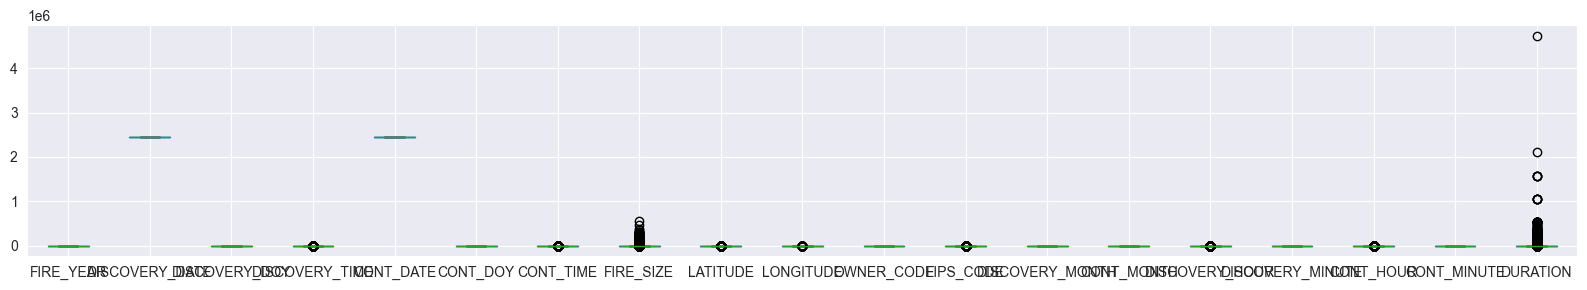

In [30]:
fires.boxplot(figsize=(20,3))
plt.show()

### Handle duration outliers:
#### For duraion:

In [31]:
duration_mean = fires['DURATION'].mean()
duration_std_dev = fires['DURATION'].std()

duration_threshold = 2 * duration_std_dev

duration_outliers_count = ((fires['DURATION'] < duration_mean - duration_threshold) | (fires['DURATION'] > duration_mean + duration_threshold)).sum()

print("Deleted outlier amount:", duration_outliers_count)
fires= fires[(fires['DURATION'] > duration_mean - duration_threshold) & (fires['DURATION'] < duration_mean + duration_threshold)]

Deleted outlier amount: 4867


#### For fire size:

In [32]:
fire_size_mean = fires['FIRE_SIZE'].mean()
fire_size_std_dev = fires['FIRE_SIZE'].std()

fire_size_threshold = 3 * fire_size_std_dev

fire_size_outliers_count = ((fires['FIRE_SIZE'] < fire_size_mean - fire_size_threshold) | (fires['FIRE_SIZE'] > fire_size_mean + fire_size_threshold)).sum()

print("Deleted outlier amount:", fire_size_outliers_count)
fires = fires[(fires['FIRE_SIZE'] > fire_size_mean - fire_size_threshold) & (fires['FIRE_SIZE'] < fire_size_mean + fire_size_threshold)]

Deleted outlier amount: 722


### Check outliers again

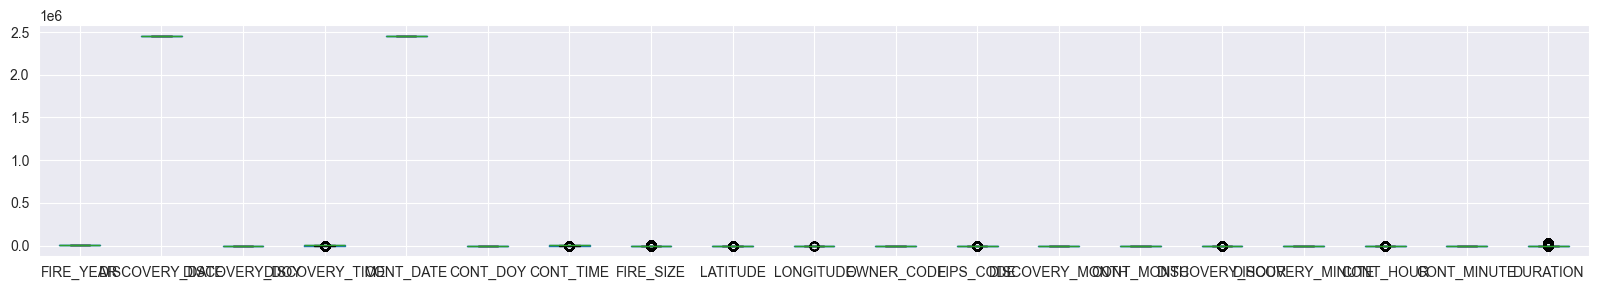

In [33]:
fires.boxplot(figsize=(20,3))
plt.show()

### Check duplicate data

In [34]:
dups = fires.duplicated()

print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 353


### Remove duplicates

In [35]:
fires = fires.drop_duplicates()

In [36]:
fires

,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,...,Gregorian_CONT_DATE,DISCOVERY_MONTH,DISCOVERY_WEEKDAY,CONT_MONTH,CONT_WEEKDAY,DISCOVERY_HOUR,DISCOVERY_MINUTE,CONT_HOUR,CONT_MINUTE,DURATION
1,FED,FS-FIRESTAT,2004,2453137.5,133,845,Lightning,2453137.5,133.0,1530,...,2004-05-12,5,Wednesday,5,Wednesday,8,45,15,30,405.0
2,FED,FS-FIRESTAT,2004,2453156.5,152,1921,Debris Burning,2453156.5,152.0,2024,...,2004-05-31,5,Monday,5,Monday,19,21,20,24,63.0
3,FED,FS-FIRESTAT,2004,2453184.5,180,1600,Lightning,2453189.5,185.0,1400,...,2004-07-03,6,Monday,7,Saturday,16,0,14,0,7080.0
4,FED,FS-FIRESTAT,2004,2453184.5,180,1600,Lightning,2453189.5,185.0,1200,...,2004-07-03,6,Monday,7,Saturday,16,0,12,0,6960.0
5,FED,FS-FIRESTAT,2004,2453186.5,182,1800,Lightning,2453187.5,183.0,1600,...,2004-07-01,6,Wednesday,7,Thursday,18,0,16,0,1320.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581146,NONFED,ST-NASF,2015,2457340.5,318,1523,Debris Burning,2457340.5,318.0,1533,...,2015-11-14,11,Saturday,11,Saturday,15,23,15,33,10.0
581147,NONFED,ST-NASF,2015,2457345.5,323,1722,Arson,2457345.5,323.0,1745,...,2015-11-19,11,Thursday,11,Thursday,17,22,17,45,23.0
581148,NONFED,ST-NASF,2015,2457298.5,276,1702,Debris Burning,2457298.5,276.0,1744,...,2015-10-03,10,Saturday,10,Saturday,17,2,17,44,42.0
581149,NONFED,ST-NASF,2015,2457310.5,288,1820,Children,2457310.5,288.0,1904,...,2015-10-15,10,Thursday,10,Thursday,18,20,19,4,44.0


## Data visualization

### Based on times:

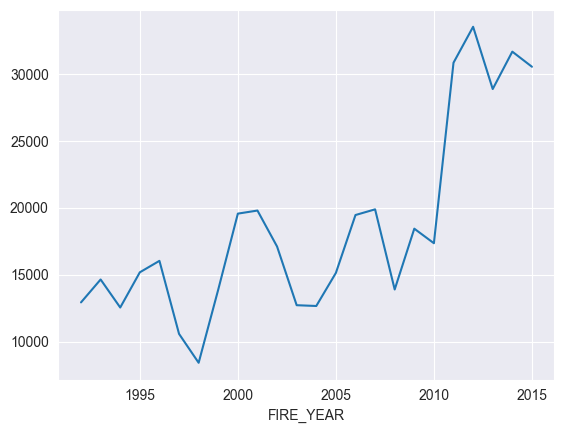

In [37]:
year_trend = fires.groupby('FIRE_YEAR').size()
year_trend.plot()
plt.show()

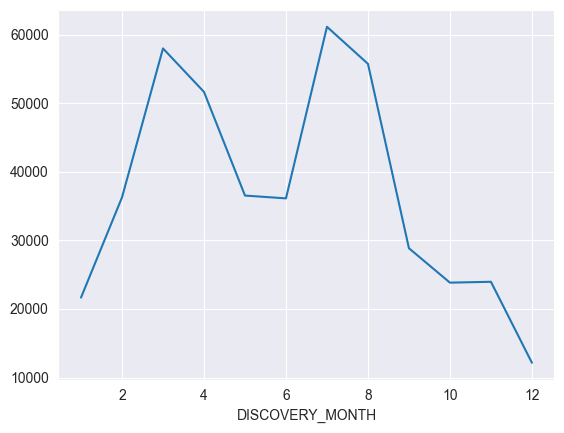

In [38]:
month_trend = fires.groupby('DISCOVERY_MONTH').size()
month_trend.plot()
plt.show()

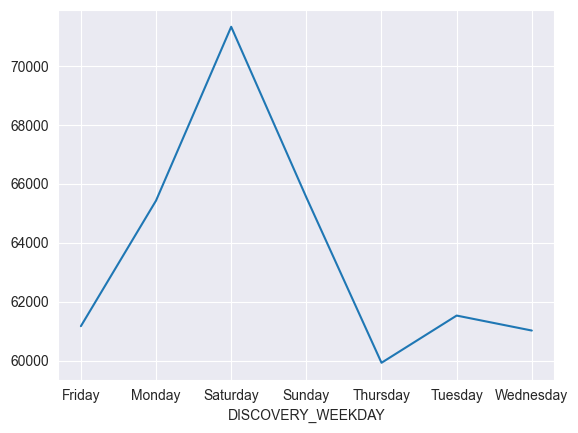

In [39]:
weekday_trend = fires.groupby('DISCOVERY_WEEKDAY').size()
weekday_trend.plot()
plt.show()

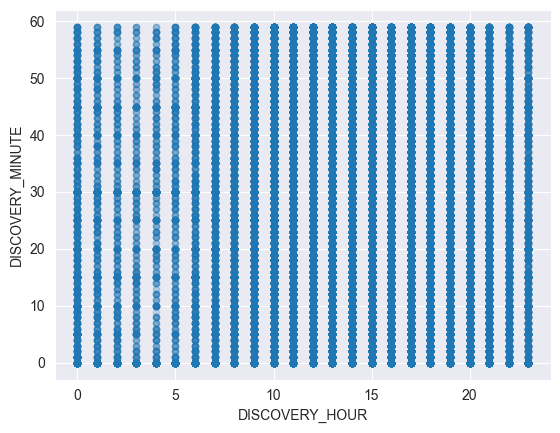

In [40]:
fires.plot(kind='scatter',x='DISCOVERY_HOUR',y='DISCOVERY_MINUTE',alpha=0.1)
plt.show()

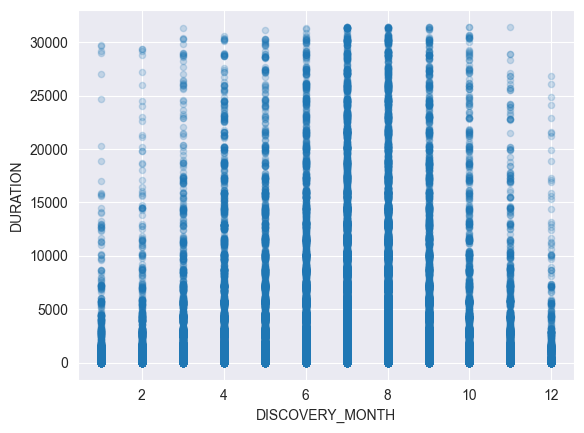

In [41]:
fires.plot(kind='scatter',x='DISCOVERY_MONTH',y='DURATION',alpha=0.2)
plt.show()

## Fire Causes:

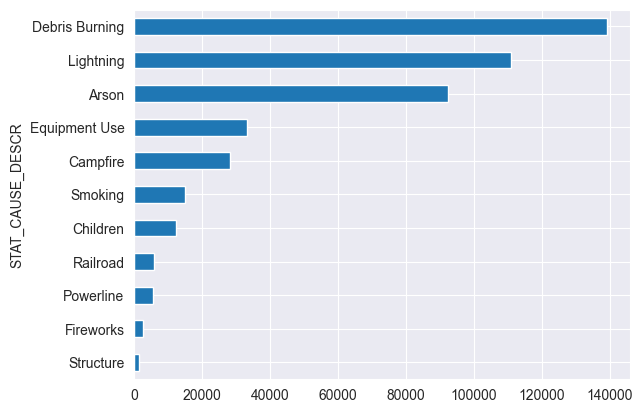

In [42]:
fires['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()

### Check the relationship between causes and time:

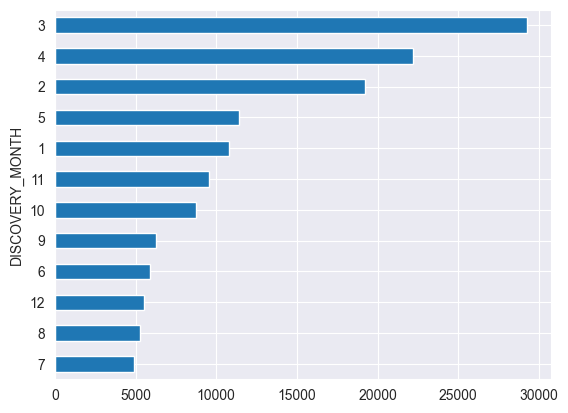

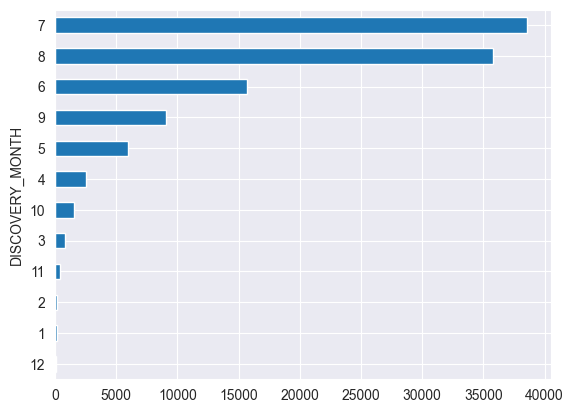

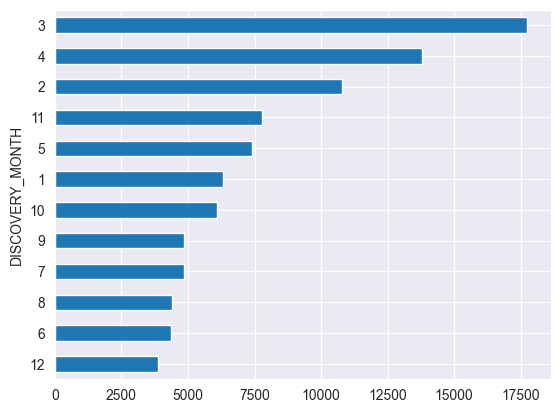

In [43]:
Debris_Burning_fire = fires[fires['STAT_CAUSE_DESCR']=='Debris Burning']
Debris_Burning_fire['DISCOVERY_MONTH'].value_counts().plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()

Lightning_fire = fires[fires['STAT_CAUSE_DESCR']=='Lightning']
Lightning_fire['DISCOVERY_MONTH'].value_counts().plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()

Arson_fire = fires[fires['STAT_CAUSE_DESCR']=='Arson']
Arson_fire['DISCOVERY_MONTH'].value_counts().plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()

### Check the relationship between causes and location:
#### State:

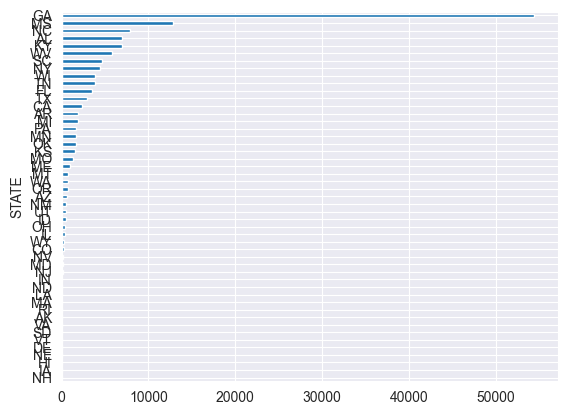

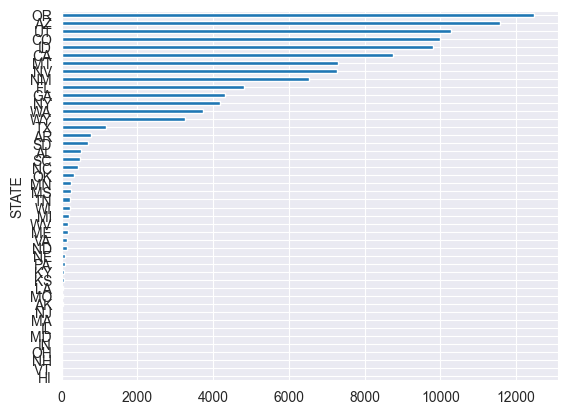

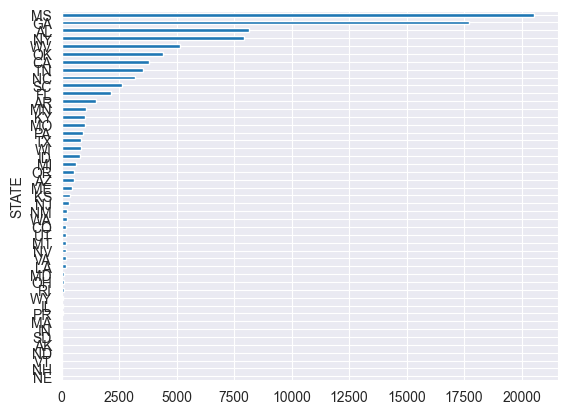

In [44]:
Debris_Burning_fire = fires[fires['STAT_CAUSE_DESCR']=='Debris Burning']
Debris_Burning_fire['STATE'].value_counts().plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()

Lightning_fire = fires[fires['STAT_CAUSE_DESCR']=='Lightning']
Lightning_fire['STATE'].value_counts().plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()

Arson_fire = fires[fires['STAT_CAUSE_DESCR']=='Arson']
Arson_fire['STATE'].value_counts().plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()

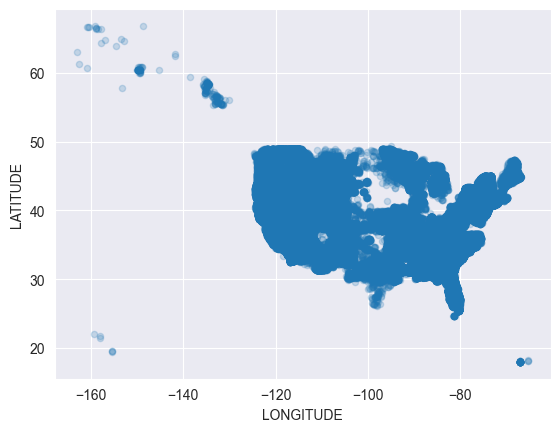

In [45]:
fires.plot(kind='scatter',x='LONGITUDE',y='LATITUDE',alpha=0.2)
plt.show()

## Check correlation:

### Encoding:

In [46]:
fires['COUNTY'] = fires['COUNTY'].astype(str)

#### Encode the string-based columns

In [47]:
Sourse_SYSTEM_TYPE_Encoder = preprocessing.LabelEncoder()
fires['SOURCE_SYSTEM_TYPE'] = Sourse_SYSTEM_TYPE_Encoder.fit_transform(fires['SOURCE_SYSTEM_TYPE'])

SOURCE_SYSTEM_Encoder = preprocessing.LabelEncoder()
fires['SOURCE_SYSTEM'] = SOURCE_SYSTEM_Encoder.fit_transform(fires['SOURCE_SYSTEM'])

STAT_CAUSE_DESCR_Encoder = preprocessing.LabelEncoder()
fires['STAT_CAUSE_DESCR'] = STAT_CAUSE_DESCR_Encoder.fit_transform(fires['STAT_CAUSE_DESCR'])

DISCOVERY_WEEKDAY_Encoder = preprocessing.LabelEncoder()
fires['DISCOVERY_WEEKDAY'] = DISCOVERY_WEEKDAY_Encoder.fit_transform(fires['DISCOVERY_WEEKDAY'])

CONT_WEEKDAY_Encoder = preprocessing.LabelEncoder()
fires['CONT_WEEKDAY'] = CONT_WEEKDAY_Encoder.fit_transform(fires['CONT_WEEKDAY'])

FIRE_SIZE_CLASS_Encoder = preprocessing.LabelEncoder()
fires['FIRE_SIZE_CLASS'] = FIRE_SIZE_CLASS_Encoder.fit_transform(fires['FIRE_SIZE_CLASS'])

OWNER_DESCR_Encoder = preprocessing.LabelEncoder()
fires['OWNER_DESCR'] = OWNER_DESCR_Encoder.fit_transform(fires['OWNER_DESCR'])

STATE_Encoder = preprocessing.LabelEncoder()
fires['STATE'] = STATE_Encoder.fit_transform(fires['STATE'])

COUNTY_Encoder = preprocessing.LabelEncoder()
fires['COUNTY'] = COUNTY_Encoder.fit_transform(fires['COUNTY'])

FIPS_NAME_Encoder = preprocessing.LabelEncoder()
fires['FIPS_NAME'] = FIPS_NAME_Encoder.fit_transform(fires['FIPS_NAME'])

#### Save encoders file

In [48]:
with open('encoders/Sourse_SYSTEM_TYPE_Encoder.pkl', 'wb') as f:
    pickle.dump(Sourse_SYSTEM_TYPE_Encoder, f)
    
with open('encoders/SOURCE_SYSTEM_Encoder.pkl', 'wb') as f:
    pickle.dump(SOURCE_SYSTEM_Encoder, f)    


with open('encoders/STAT_CAUSE_DESCR_Encoder.pkl', 'wb') as f:
    pickle.dump(STAT_CAUSE_DESCR_Encoder, f)

with open('encoders/DISCOVERY_WEEKDAY_Encoder.pkl', 'wb') as f:
    pickle.dump(DISCOVERY_WEEKDAY_Encoder, f)

with open('encoders/CONT_WEEKDAY_Encoder.pkl', 'wb') as f:
    pickle.dump(CONT_WEEKDAY_Encoder, f)

with open('encoders/FIRE_SIZE_CLASS_Encoder.pkl', 'wb') as f:
    pickle.dump(FIRE_SIZE_CLASS_Encoder, f)

with open('encoders/OWNER_DESCR_Encoder.pkl', 'wb') as f:
    pickle.dump(OWNER_DESCR_Encoder, f)

with open('encoders/STATE_Encoder.pkl', 'wb') as f:
    pickle.dump(STATE_Encoder, f)

with open('encoders/COUNTY_Encoder.pkl', 'wb') as f:
    pickle.dump(COUNTY_Encoder, f)

with open('encoders/FIPS_NAME_Encoder.pkl', 'wb') as f:
    pickle.dump(FIPS_NAME_Encoder, f)    

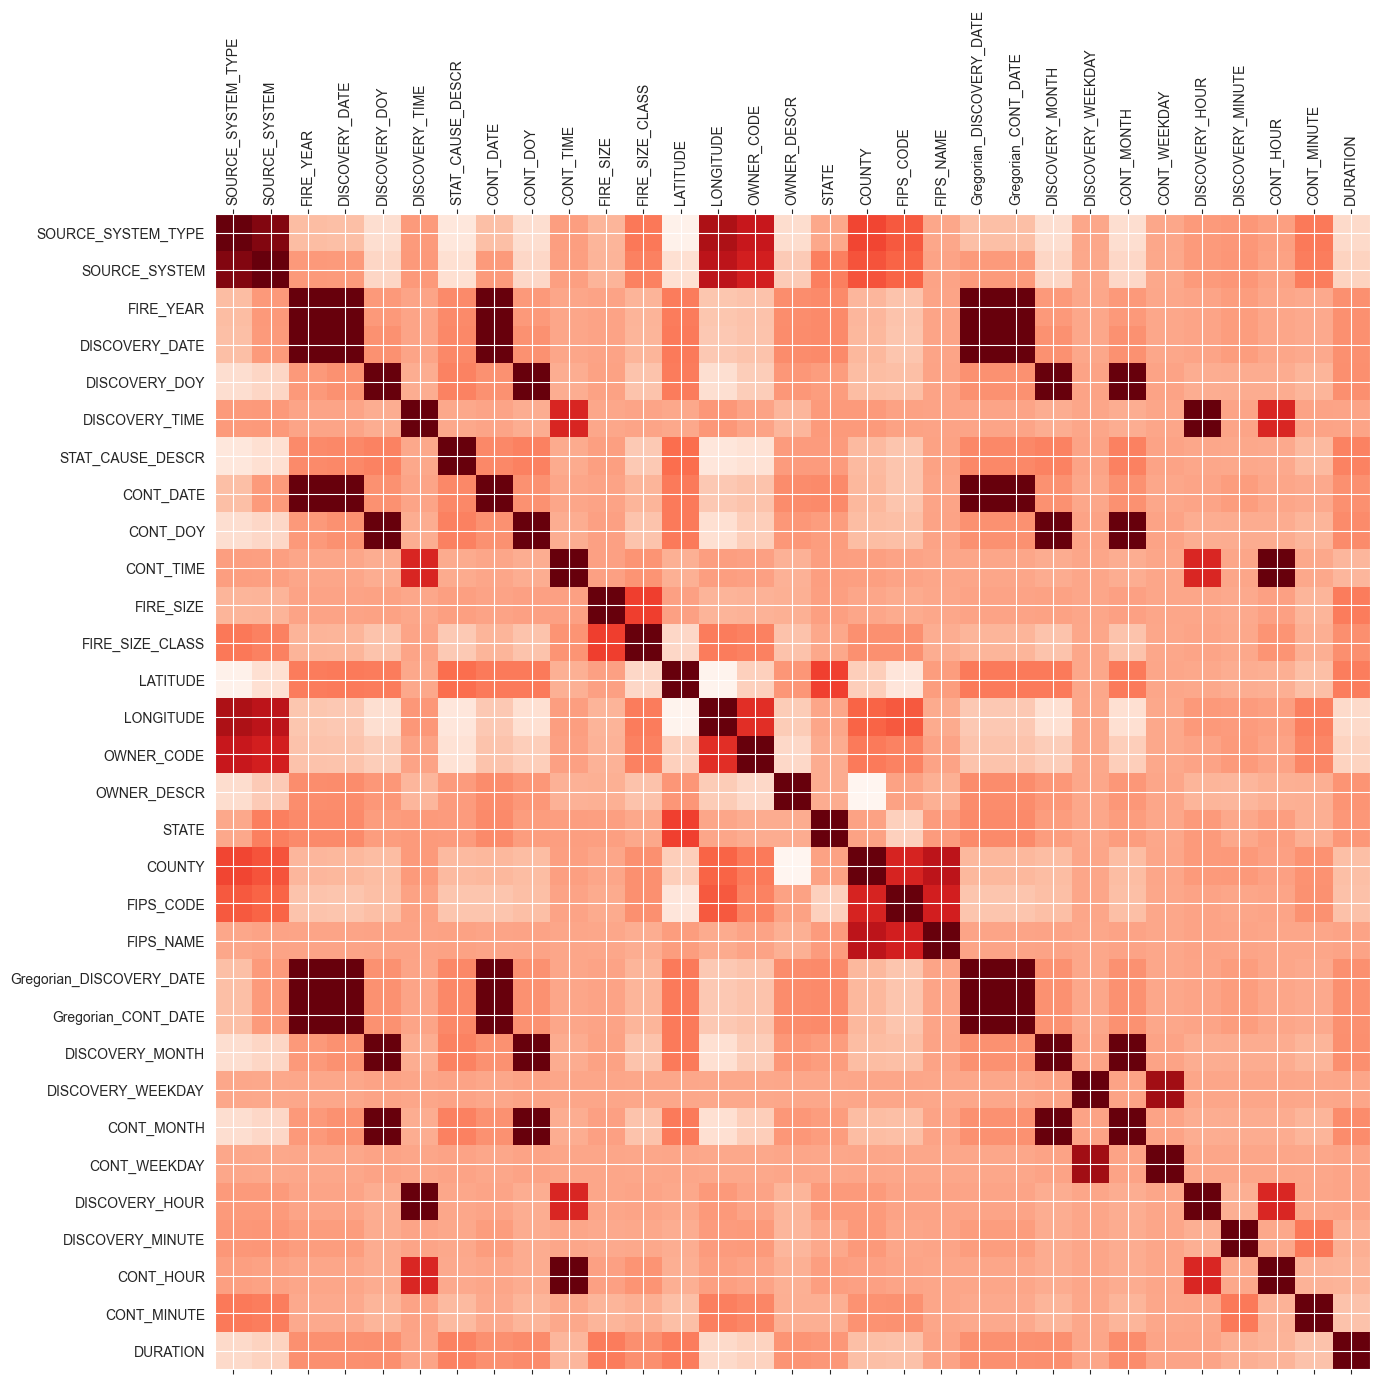

In [49]:
corr = fires.corr()
fig, ax = plt.subplots(figsize=(15, 15))
ax.matshow(corr,cmap=plt.cm.Reds)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)    
plt.show()

In [50]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
Index: 445955 entries, 1 to 581151
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SOURCE_SYSTEM_TYPE        445955 non-null  int64         
 1   SOURCE_SYSTEM             445955 non-null  int64         
 2   FIRE_YEAR                 445955 non-null  int64         
 3   DISCOVERY_DATE            445955 non-null  float64       
 4   DISCOVERY_DOY             445955 non-null  int64         
 5   DISCOVERY_TIME            445955 non-null  int64         
 6   STAT_CAUSE_DESCR          445955 non-null  int64         
 7   CONT_DATE                 445955 non-null  float64       
 8   CONT_DOY                  445955 non-null  float64       
 9   CONT_TIME                 445955 non-null  int64         
 10  FIRE_SIZE                 445955 non-null  float64       
 11  FIRE_SIZE_CLASS           445955 non-null  int64         
 12  LATITUD

In [51]:
cleaned_data = fires

In [52]:
cleaned_data = cleaned_data.drop(columns = ['Gregorian_DISCOVERY_DATE', 'Gregorian_CONT_DATE', 'DISCOVERY_DATE', 'CONT_DATE'
                            , 'SOURCE_SYSTEM_TYPE', 'FIRE_SIZE_CLASS', 'DISCOVERY_TIME', 'CONT_TIME'
                            ], axis =1)

In [53]:
cleaned_data.to_csv('cleaned_data.csv', index=False)